In [7]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Define data folder and crop types
data_folder = 'Desktop/DataCrop/'  # Path to the folder containing the images
crop_types = ['wheat', 'rice', 'sugarcane', 'maize', 'jute']  # Types of crops
augmented_images = []
num_images_per_class = 159  # Desired number of images per class

# Create an augmentation generator
augmentation_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Iterate over each crop class
for label, crop in enumerate(crop_types):
    crop_folder = os.path.join(data_folder, crop)
    images_in_class = [os.path.join(crop_folder, filename) for filename in os.listdir(crop_folder)]

    # Generate augmented images to reach the desired number
    generated_images = 0
    while generated_images < num_images_per_class:
        for img_path in images_in_class:
            img = Image.open(img_path)
            img = img.resize((224, 224))  # Resize if necessary
            img = np.array(img) / 255.0  # Normalize pixel values
            
            # Generate an augmented image
            augmented_img = augmentation_generator.random_transform(img)
            augmented_images.append((augmented_img, label))  # Add image and its label
            generated_images += 1
            
            # Check if desired number of augmented images is reached
            if generated_images == num_images_per_class:
                break

# Check the total number of generated augmented images
print(f"Total number of augmented images: {len(augmented_images)}")

Total number of augmented images: 795


In [2]:
# Splitting the data into train (80%) and temp (20%)
train_temp_images, test_images_labels = train_test_split(augmented_images, test_size=0.2, random_state=42)

# Further splitting 'temp' into val (50%) and test (50%)
val_images, test_images_labels = train_test_split(test_images_labels, test_size=0.5, random_state=42)

# Separating images and labels for each set
train_images, train_labels = zip(*train_temp_images)
val_images, val_labels = zip(*val_images)
test_images, test_labels = zip(*test_images_labels)

# Checking the sizes of the sets
print(f"Train set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")

Train set: 636 images
Validation set: 79 images
Test set: 80 images


In [3]:
# Convert the data splits and labels to NumPy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)


In [9]:
# Load the pre-trained VGG16 model without the top classification layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in vgg_base.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(vgg_base)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))  # Adapted for 16 plant classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using your data
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))


Epoch 1/10
20/20 [==============================] - 250s 12s/step - loss: 1.3756 - accuracy: 0.5582 - val_loss: 1.7071 - val_accuracy: 0.3544
Epoch 2/10
20/20 [==============================] - 218s 11s/step - loss: 0.2130 - accuracy: 0.9308 - val_loss: 1.4129 - val_accuracy: 0.3671
Epoch 3/10
20/20 [==============================] - 208s 10s/step - loss: 0.0659 - accuracy: 0.9780 - val_loss: 1.1930 - val_accuracy: 0.4684
Epoch 4/10
20/20 [==============================] - 208s 10s/step - loss: 0.0207 - accuracy: 0.9984 - val_loss: 1.1255 - val_accuracy: 0.5443
Epoch 5/10
20/20 [==============================] - 201s 10s/step - loss: 0.0098 - accuracy: 0.9984 - val_loss: 1.0461 - val_accuracy: 0.5570
Epoch 6/10
20/20 [==============================] - 207s 10s/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.9192 - val_accuracy: 0.5949
Epoch 7/10
20/20 [==============================] - 216s 11s/step - loss: 0.0088 - accuracy: 0.9984 - val_loss: 0.8924 - val_accuracy: 0.6456
Epoch 

In [10]:
# Predict classes for test set
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_classes)
precision = precision_score(test_labels, predicted_classes, average='macro')
recall = recall_score(test_labels, predicted_classes, average='macro')
f1 = f1_score(test_labels, predicted_classes, average='macro')
conf_matrix = confusion_matrix(test_labels, predicted_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


3/3 [==============================] - 22s 7s/step
Accuracy: 0.6875
Precision: 0.7491249491249491
Recall: 0.691240374692387
F1 Score: 0.6939075374666881
Confusion Matrix:
[[11  3  1  2  0]
 [ 1 14  1  0  0]
 [ 0  2 10  1  0]
 [ 0  6  1 12  0]
 [ 1  2  1  3  8]]


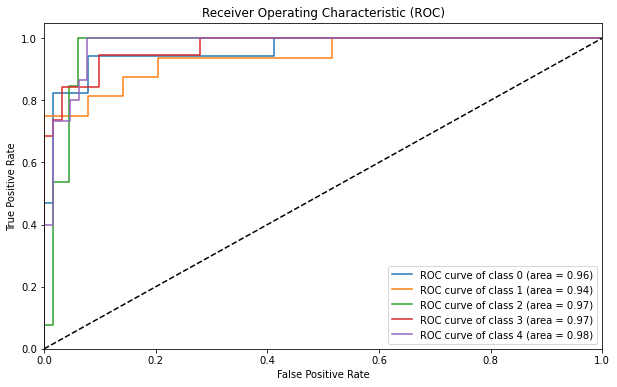

In [16]:
# Binarize the labels
binarized_labels = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Assuming predictions contain probabilities for each class (shape: [num_samples, num_classes])
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [4]:

# Load the InceptionV3 model pretrained on ImageNet data
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in inception_base.layers:
    layer.trainable = False

# Create a new model on top of the InceptionV3 base
model2 = Sequential()
model2.add(inception_base)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(5, activation='softmax'))  # Adapted for 5 plant classes

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using your data
history = model2.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))


Epoch 1/10
20/20 [==============================] - 63s 3s/step - loss: 1.6315 - accuracy: 0.4041 - val_loss: 1.2537 - val_accuracy: 0.4684
Epoch 2/10
20/20 [==============================] - 48s 2s/step - loss: 0.8344 - accuracy: 0.7013 - val_loss: 0.8204 - val_accuracy: 0.6962
Epoch 3/10
20/20 [==============================] - 45s 2s/step - loss: 0.5188 - accuracy: 0.8349 - val_loss: 0.7376 - val_accuracy: 0.6835
Epoch 4/10
20/20 [==============================] - 49s 2s/step - loss: 0.3542 - accuracy: 0.8978 - val_loss: 0.6466 - val_accuracy: 0.7595
Epoch 5/10
20/20 [==============================] - 51s 3s/step - loss: 0.2519 - accuracy: 0.9465 - val_loss: 0.5950 - val_accuracy: 0.7848
Epoch 6/10
20/20 [==============================] - 51s 3s/step - loss: 0.1660 - accuracy: 0.9764 - val_loss: 0.5504 - val_accuracy: 0.7722
Epoch 7/10
20/20 [==============================] - 50s 3s/step - loss: 0.1217 - accuracy: 0.9921 - val_loss: 0.5280 - val_accuracy: 0.7848
Epoch 8/10
20/20 [==

In [20]:
# Predict classes for test set
predictions = model2.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_classes)
precision = precision_score(test_labels, predicted_classes, average='macro')
recall = recall_score(test_labels, predicted_classes, average='macro')
f1 = f1_score(test_labels, predicted_classes, average='macro')
conf_matrix = confusion_matrix(test_labels, predicted_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

3/3 [==============================] - 7s 2s/step
Accuracy: 0.7875
Precision: 0.7952168746286394
Recall: 0.7964703897753433
F1 Score: 0.7891673167940916
Confusion Matrix:
[[14  1  1  1  0]
 [ 0 15  1  0  0]
 [ 0  1 12  0  0]
 [ 3  1  2 12  1]
 [ 1  0  0  4 10]]


3/3 [==============================] - 5s 2s/step


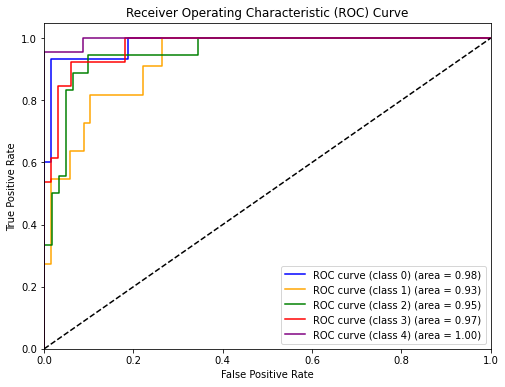

In [8]:
# Make predictions on the validation set
val_predictions = model2.predict(val_images)

# Get the number of classes
num_classes = len(np.unique(train_labels))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((val_labels == i).astype(int), val_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Change or add colors based on the number of classes

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()


In [ ]:
model2.save('inceptionv3_model.h5')
model.save('vgg_model.h5')